Improvement: Redefine tail_contour_li_threshold_grayscale_input.  
Now before finding threshold, we'll add left - right vertical borders, width = 5 pixels each 

In [2]:
import skimage
from skimage import measure
import matplotlib.pyplot as plt
from skimage import data, io, color
from skimage.filters import threshold_li
from skimage.filters import try_all_threshold
from skimage.color import rgb2hsv
import numpy as np
from matplotlib import path
from matplotlib.path import Path
import matplotlib.patches as patches
import math

# Generate images

In [5]:
# Function to apply a Value filter to input image
# Input: Path to image
# Output: image converted to 2-dimensional array, with Value reduced to 0, Hue and Saturation unchanged
def hsv_value_filter(imgpath):
    rgb_img = skimage.io.imread(imgpath)
    hsv_img = rgb2hsv(rgb_img)
    value_img = hsv_img[:, :, 2]
    return value_img


# Function to find contour line from grayscale image
# Input: Grayscale image (2-dimensional array with values from 0-1)
# output: Contour line
def tail_contour_li_threshold_grayscale_input(tail_img_gray):
    #tail_img_gray = color.rgb2gray(tail_img)  
    mask_threshold = threshold_li(tail_img_gray)
    tail_img_mask = tail_img_gray < mask_threshold
    
    # Improvement 13.1: Add left - right borders 5 pixels each
    tail_img_mask[:,0:5] = 0
    tail_img_mask[:,-6:-1] = 0
    
    contours = measure.find_contours(tail_img_mask, 0.9) 
    # Find the largest contour in the list of contours
    contours.sort(key=len,reverse=True)
    largest_contour = contours[0]
    return largest_contour

# https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
# Function to rotate a set of points around an origin by a predefined degrees
# Input: set of points, for example a contour line; origin of rotation; rotation angle in degree
# Output: the same set of points rotated
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

# Function to extract edge line from a given contour. 
# Edge line is tilted so that the straight line connecting left-right tips is parallel with x axis
# Input: contour line
# Ourput: edge line, tilted horizontally
def extract_edge_tilt(contour):
    # Move contour to line towards root (0,0)
    contour[:,0] -= contour[:,0].min()
    contour[:,1] -= contour[:,1].min()

    # Get middle y point of contour line
    middle_y = (contour[:,0].max() - contour[:,0].min())/2

    # FIND NOTCH POINT
    # Get 25% and 75% on x as left and right boundaries to find notch point
    left_bound = contour[:,1].max() * 0.25
    right_bound = contour[:,1].max() * 0.75

    # Cut the area containing notch point by middle_y, left and right boundaries
    c_notch = contour[ (contour[:,0] < middle_y) & (contour[:,1] > left_bound) & (contour[:,1] < right_bound)]

    # If there is no point in the notch area => bad contour line, stops finding edge & returns bottom half of the contour image
    if (len(c_notch) == 0):
        return contour[(contour[:,0] < middle_y)]

    # Find notch points == points that have the highest y in the notch area
    c_notch_y = c_notch[:,0].max()
    c_notch_points = c_notch[c_notch[:,0] == c_notch_y]

    notch_point = c_notch_points[0]

    # FIND LEFT-RIGHT TIPS OF THE FLUKE
    # Cut the bottom half of the tail
    c_bottom = contour[ (contour[:,0] < middle_y)]
    # Find the left tip
    left_tip_x = c_bottom[:,1].min()
    left_tips = c_bottom[c_bottom[:,1] == left_tip_x]
    left_tip = left_tips[0] # if there are several points at min_x
    # Find the right tip
    right_tip_x = c_bottom[:,1].max()
    right_tips = c_bottom[c_bottom[:,1] == right_tip_x]
    right_tip = right_tips[-1] # if there are several points at max_x
    
    # CREATE A PATH OBJECT THAT BOUNDS THE FLUKE
    # The path is limited by 5 points: bottom_left,left_tip, notch_point, right_tip,bottom_right
    bottom_left = np.array([0,left_tip[1]])
    bottom_right = np.array([0,right_tip[1]])
    verts = [bottom_left,left_tip, notch_point, right_tip,bottom_right,bottom_left]
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    edge_path = Path(verts, codes)
    
    # Extract the edge from bottom half of the image using the path as a mask
    c_edge = c_bottom[edge_path.contains_points(c_bottom)]
    
    # Identify the tilt angle
    diff = right_tip - left_tip
    tilt_angle = np.rad2deg(math.atan(diff[0]/diff[1]))
    
    # Identify rotate center - midpoint of left and right tips
    rotate_center = ((left_tip[0]+right_tip[0])/2,(left_tip[1]+right_tip[1])/2)
        
    # Rotate the edge to balance horizontally around the rotate center
    c_edge_tilted = rotate(c_edge, origin=rotate_center, degrees=tilt_angle)
    return c_edge_tilted

In [5]:
def save_edge(source_img_path, output_path):
    # Load the image, convert to hsv and reduce Value to 0
    tail_img_filtered = hsv_value_filter(source_img_path)
          
    c = tail_contour_li_threshold_grayscale_input(tail_img_filtered)
    edge = extract_edge_tilt(c)
    
    # Save image to output_path
    # fig = plt.figure(figsize=(8,3)) # Experiment 6.0: scaled y; fixed size for all output image
    
    fig = plt.figure(figsize=(8,3))  # Experiment 6.1: No scaling output images
    #fig = plt.figure(figsize=(16,6))  # Experiment 6.2: No scaling output images; increased output img size
    plt.gca().set_aspect('equal', adjustable='box') # ensure 2 axes are on the same scale
    
    # Experiment 6.3: Resize output image closest to the size fed into MobileNet (224x224)
    #my_dpi=96 # This combination returns output images with size (224x219), best try
    #fig = plt.figure(figsize=(2.76, 2.76), dpi=my_dpi)
    #plt.axis('equal')
    
    plt.plot(edge[:, 1], edge[:, 0],  linewidth=1, color = 'black')  
    plt.axis('off')
    plt.savefig(output_path, cmap = "gray", bbox_inches='tight') # Experiments 6.0, 6.1, 6.2
    #plt.savefig(output_path, cmap = "gray", bbox_inches='tight', dpi=my_dpi) # Experiment 6.3
    plt.close(fig) # do not plot the image to screen

In [6]:
# Store test-val
import os
testval_path = "../data/test_val/"
testval_contour_path = "../experiments/13. tuning_edges_add_borders/test-val/"

images = os.listdir(testval_path)

img_count = len(images)
i = 0

for img in images:
    in_file = testval_path + img
    out_file = testval_contour_path + img
    save_edge(in_file, out_file)
    
    #progress tracking
    i += 1
    if (i%10 == 0):
        print("processed {}/{} images ({}%)".format(i,img_count,round(i/img_count*100,2)))

processed 10/808 images (1.24%)
processed 20/808 images (2.48%)
processed 30/808 images (3.71%)
processed 40/808 images (4.95%)
processed 50/808 images (6.19%)
processed 60/808 images (7.43%)
processed 70/808 images (8.66%)
processed 80/808 images (9.9%)
processed 90/808 images (11.14%)
processed 100/808 images (12.38%)
processed 110/808 images (13.61%)
processed 120/808 images (14.85%)
processed 130/808 images (16.09%)
processed 140/808 images (17.33%)
processed 150/808 images (18.56%)
processed 160/808 images (19.8%)
processed 170/808 images (21.04%)
processed 180/808 images (22.28%)
processed 190/808 images (23.51%)
processed 200/808 images (24.75%)
processed 210/808 images (25.99%)
processed 220/808 images (27.23%)
processed 230/808 images (28.47%)
processed 240/808 images (29.7%)
processed 250/808 images (30.94%)
processed 260/808 images (32.18%)
processed 270/808 images (33.42%)
processed 280/808 images (34.65%)
processed 290/808 images (35.89%)
processed 300/808 images (37.13%)


In [7]:
# Store train
import os
train_path = "../data/train/"
train_contour_path =  "../experiments/13. tuning_edges_add_borders/train/"

subfolders = os.listdir(train_path)

train_file_count = 4539 - 577 # We know in advance the number of training images, in whih 577 images belong to class -1
i=0

for sf in subfolders:
    #Skip folder -1 
    if (sf == '-1'):
        continue 
    
    # Create sub-folder for train contours if not exist
    train_contour_path_subfolder = train_contour_path + sf
    if not os.path.exists(train_contour_path_subfolder):
        os.makedirs(train_contour_path_subfolder)  
    
    # Get list of images in each subfolder
    images = os.listdir(train_path + sf)
    # Find contour for each image
    for img in images:
        in_file = train_path + sf + "/" + img
        out_file = train_contour_path + sf + "/" + img
        save_edge(in_file, out_file)
        #progress tracking
        i += 1
        if (i%10 == 0):
            print("processed {}/{} images ({}%)".format(i,train_file_count,round(i/train_file_count*100,2)))

processed 10/3962 images (0.25%)
processed 20/3962 images (0.5%)
processed 30/3962 images (0.76%)
processed 40/3962 images (1.01%)
processed 50/3962 images (1.26%)
processed 60/3962 images (1.51%)
processed 70/3962 images (1.77%)
processed 80/3962 images (2.02%)
processed 90/3962 images (2.27%)
processed 100/3962 images (2.52%)
processed 110/3962 images (2.78%)
processed 120/3962 images (3.03%)
processed 130/3962 images (3.28%)
processed 140/3962 images (3.53%)
processed 150/3962 images (3.79%)
processed 160/3962 images (4.04%)
processed 170/3962 images (4.29%)
processed 180/3962 images (4.54%)
processed 190/3962 images (4.8%)
processed 200/3962 images (5.05%)
processed 210/3962 images (5.3%)
processed 220/3962 images (5.55%)
processed 230/3962 images (5.81%)
processed 240/3962 images (6.06%)
processed 250/3962 images (6.31%)
processed 260/3962 images (6.56%)
processed 270/3962 images (6.81%)
processed 280/3962 images (7.07%)
processed 290/3962 images (7.32%)
processed 300/3962 images 

processed 2340/3962 images (59.06%)
processed 2350/3962 images (59.31%)
processed 2360/3962 images (59.57%)
processed 2370/3962 images (59.82%)
processed 2380/3962 images (60.07%)
processed 2390/3962 images (60.32%)
processed 2400/3962 images (60.58%)
processed 2410/3962 images (60.83%)
processed 2420/3962 images (61.08%)
processed 2430/3962 images (61.33%)
processed 2440/3962 images (61.59%)
processed 2450/3962 images (61.84%)
processed 2460/3962 images (62.09%)
processed 2470/3962 images (62.34%)
processed 2480/3962 images (62.59%)
processed 2490/3962 images (62.85%)
processed 2500/3962 images (63.1%)
processed 2510/3962 images (63.35%)
processed 2520/3962 images (63.6%)
processed 2530/3962 images (63.86%)
processed 2540/3962 images (64.11%)
processed 2550/3962 images (64.36%)
processed 2560/3962 images (64.61%)
processed 2570/3962 images (64.87%)
processed 2580/3962 images (65.12%)
processed 2590/3962 images (65.37%)
processed 2600/3962 images (65.62%)
processed 2610/3962 images (65

# Exploration after adding borders

In [27]:
def show_img(img_path):
    print(img_path)
    fig,axes = plt.subplots(2, 2, figsize=(24,12))

    rgb_img= io.imread(img_path)
    axes[0, 0].set_title('raw image')
    axes[0, 0].imshow(rgb_img, interpolation='nearest'); 

    hsv_img = rgb2hsv(rgb_img)
    value_img = hsv_img[:, :, 2]
    #fig = plt.figure()
    axes[0, 1].set_title('hsv - v channel')
    axes[0, 1].imshow(value_img, cmap='hsv')

    mask_threshold = threshold_li(value_img)
    tail_img_mask = value_img < mask_threshold
    
    # Improvement 13.1: Add left - right borders 5 pixels each
    tail_img_mask[:,0:5] = 0
    tail_img_mask[:,-6:-1] = 0
    
    #fig = plt.figure()
    #plt.imshow(tail_img_mask, cmap='gray')

    contours = measure.find_contours(tail_img_mask, 0.9) 
    # Find the largest contour in the list of contours
    contours.sort(key=len,reverse=True)
    largest_contour = contours[0]
    c1 = contours[0]
    c2 = contours[1]
    c3 = contours[2]
    #fig = plt.figure()
    axes[1, 0].set_title('mask + 3 largest contours (r-g-b)')
    axes[1, 0].imshow(tail_img_mask, cmap='gray')
    axes[1, 0].plot(largest_contour[:, 1], largest_contour[:, 0],  linewidth=3, color = 'red') 
    axes[1, 0].plot(c1[:, 1], c1[:, 0],  linewidth=3, color = 'red') 
    axes[1, 0].plot(c2[:, 1], c2[:, 0],  linewidth=3, color = 'green') 
    axes[1, 0].plot(c3[:, 1], c3[:, 0],  linewidth=3, color = 'blue')
    

    #fig = plt.figure()
    axes[1, 1].set_title('contour fit on raw img')
    axes[1, 1].imshow(rgb_img, interpolation='nearest'); 
    axes[1, 1].plot(largest_contour[:, 1], largest_contour[:, 0],  linewidth=2, color = 'red') 

    contour = largest_contour
    # Move contour to line towards root (0,0)
    contour[:,0] -= contour[:,0].min()
    contour[:,1] -= contour[:,1].min()

    # Get middle y point of contour line
    middle_y = (contour[:,0].max() - contour[:,0].min())/2

    # FIND NOTCH POINT
    # Get 25% and 75% on x as left and right boundaries to find notch point
    left_bound = contour[:,1].max() * 0.25
    right_bound = contour[:,1].max() * 0.75

    # Cut the area containing notch point by middle_y, left and right boundaries
    c_notch = contour[ (contour[:,0] < middle_y) & (contour[:,1] > left_bound) & (contour[:,1] < right_bound)]

    # If there is no point in the notch area => bad contour line, returns empty (can't find notch point)
    if (len(c_notch) == 0):
        notch_point = []

    # Find notch points == points that have the highest y in the notch area
    c_notch_y = c_notch[:,0].max()
    c_notch_points = c_notch[c_notch[:,0] == c_notch_y]

    notch_point = c_notch_points[0]

    # FIND LEFT-RIGHT TIPS OF THE FLUKE
    # Cut the bottom half of the tail
    c_bottom = contour[ (contour[:,0] < middle_y)]
    # Find the left tip
    left_tip_x = c_bottom[:,1].min()
    left_tips = c_bottom[c_bottom[:,1] == left_tip_x]
    left_tip = left_tips[0] # if there are several points at min_x
    # Find the right tip
    right_tip_x = c_bottom[:,1].max()
    right_tips = c_bottom[c_bottom[:,1] == right_tip_x]
    right_tip = right_tips[-1] # if there are several points at max_x
    fig = plt.figure(figsize=(8,3)) 
    #plt.gca().invert_yaxis() # set cordinate root (0,0) to top left point
    plt.plot(notch_point[1], notch_point[0], marker='o', markersize=10, color="red")
    plt.plot(left_tip[1], left_tip[0], marker='o', markersize=10, color="red")
    plt.plot(right_tip[1], right_tip[0], marker='o', markersize=10, color="red")
    plt.plot(contour[:, 1], contour[:, 0],  linewidth=2, color = 'black')  
    bottom_left = np.array([0,left_tip[1]])
    bottom_right = np.array([0,right_tip[1]])
    verts = [bottom_left,left_tip, notch_point, right_tip,bottom_right,bottom_left]
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    path = Path(verts, codes)

    fig, ax = plt.subplots(figsize = [3,6])
    patch = patches.PathPatch(path, facecolor='orange', lw=2)
    ax.add_patch(patch)
    ax.set_xlim(0, notch_point[0]*3)
    ax.set_ylim(0, right_tip[1])
    ax.plot(contour[:, 0], contour[:, 1],  linewidth=2, color = 'black')  
    plt.show()
    c_edge = c_bottom[path.contains_points(c_bottom)]
    fig = plt.figure(figsize=(8,3)) 
    #plt.gca().invert_yaxis() # set cordinate root (0,0) to top left point
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(notch_point[1], notch_point[0], marker='o', markersize=10, color="red")
    plt.plot(left_tip[1], left_tip[0], marker='o', markersize=10, color="red")
    plt.plot(right_tip[1], right_tip[0], marker='o', markersize=10, color="red")
    plt.plot(c_edge[:, 1], c_edge[:, 0],  linewidth=2, color = 'black')  
    diff = right_tip - left_tip
    tilt_angle = np.rad2deg(math.atan(diff[0]/diff[1]))
    r_img = rotate(c_edge, origin=left_tip, degrees=tilt_angle)
    fig = plt.figure(figsize=(8,3)) 
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.gca().invert_yaxis() # set cordinate root (0,0) to top left point
    plt.plot(c_edge[:, 1], c_edge[:, 0],  linewidth=3, color = 'red')  
    #plt.plot((rotate_center[0],points[0][0]), (rotate_center[1],points[0][1]),  linewidth=1, color = 'red')
    #plt.plot((rotate_center[0],points[1][0]), (rotate_center[1],points[1][1]),  linewidth=1, color = 'red')
    plt.plot(r_img[:, 1], r_img[:, 0],  linewidth=3, color = 'blue')  
    #plt.plot((rotate_center[0],new_points[0][0]), (rotate_center[1],new_points[0][1]),  linewidth=1, color = 'blue')
    #plt.plot((rotate_center[0],new_points[1][0]), (rotate_center[1],new_points[1][1]),  linewidth=1, color = 'blue')
    plt.plot(left_tip[1], left_tip[0], marker='o', markersize=10, color="green")
    fig = plt.figure(figsize=(8,3)) 
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(r_img[:, 1], r_img[:, 0],  linewidth=2, color = 'black')  

../data/test_val/PM-WWA-20170510-814.jpg


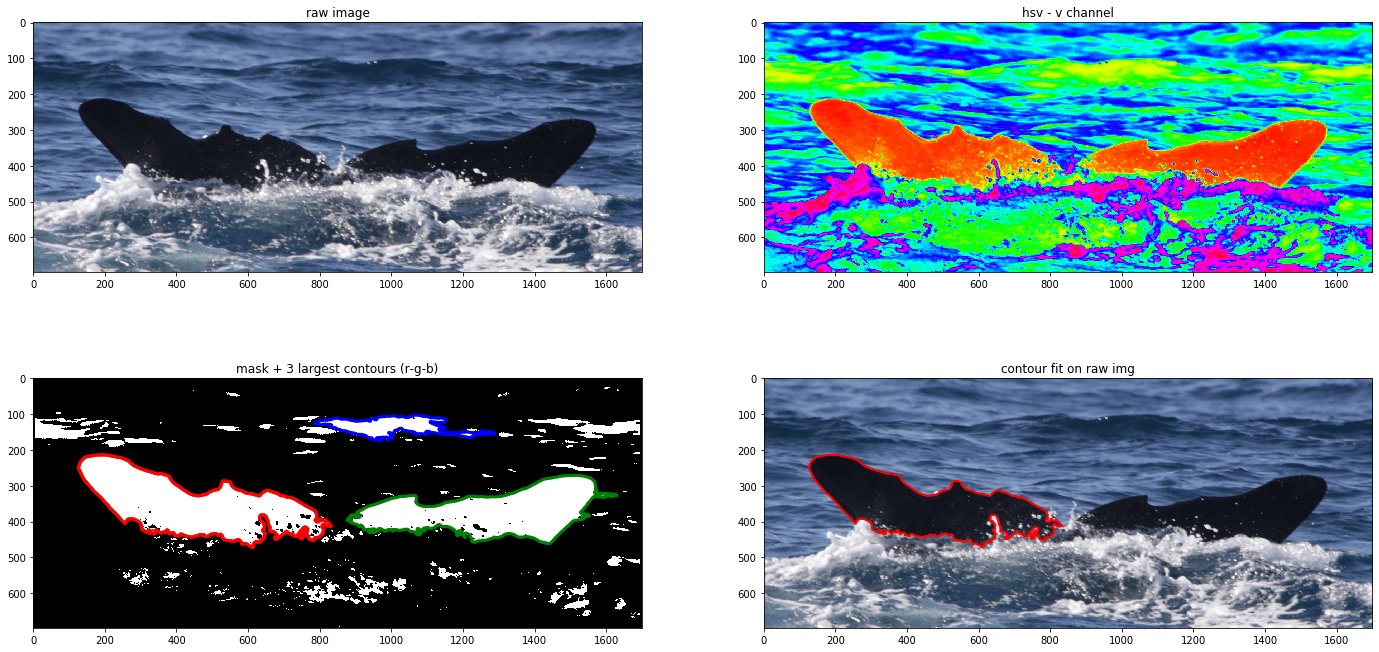

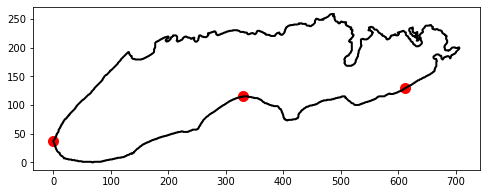

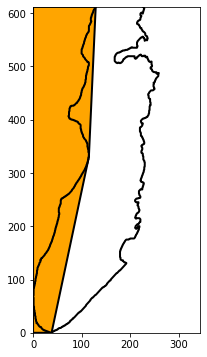

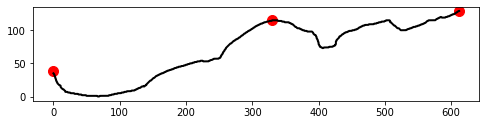

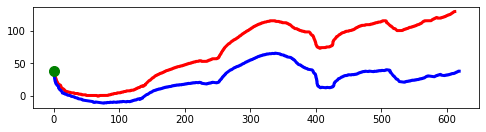

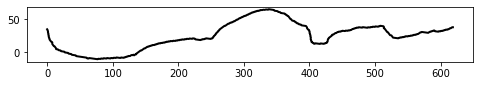

In [29]:
img = '../data/test_val/PM-WWA-20180917-311.jpg'
img = '../data/test_val/PM-WWA-20170510-814.jpg'
show_img(img)